# Prelim

In [1]:
import re
import pandas as pd
import os
import pickle
import seaborn as sns
import numpy as np
import sys
sys.path.append("/Users/jiahang/Documents/dagma/src/dagma/")
import utils
import matplotlib.pyplot as plt
import utils_dagma
import networkx as nx

def load_data(n_nodes, seed, version_path):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'{version_path}/W/W_{seed}_0.pkl'), 'rb') as f:
        W = pickle.load(f)
    with open(os.path.join(root_path, f'{version_path}/X/X_1.pkl'), 'rb') as f:
        X = pickle.load(f)
    W_est = W['W_est']
    W = W['W_est'][:, :n_nodes]
    Z = np.abs(W[:n_nodes]) - np.abs(W[n_nodes:])
    W_true = X['W_true']
    X = X['X']
    B_true = (W_true != 0)
    
    return X, B_true, W_est, W_true

def get_block(data, n_nodes=20, index=11, extract=None):
    data_dict = {
        11: data[:n_nodes, :n_nodes],
        12: data[:n_nodes, n_nodes:],
        21: data[n_nodes:, :n_nodes],
        22: data[n_nodes:, n_nodes:]
    }
    
    return data_dict[index]

def get_Z(data, n_nodes=20, left=11, right=21, extract=None):
    left_block = get_block(data, n_nodes, left)
    right_block = get_block(data, n_nodes, right)
    res = np.abs(left_block) - np.abs(right_block)
    
    return res

def get_cutoff(Z11_21):
    fdr_est_last = 1.
    t_last = np.inf
    t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z11_21)))))
    
    for t in reversed(t_list):
        if t < 0.:
            break
        
        fdr_est = (1 + (Z11_21 <= -t).sum()) / np.max((1, (Z11_21 >= t).sum()))
        
        if fdr_est <= 0.2:
            t_last = t
            fdr_est_last = fdr_est
    return t_last

def draw_strip(n_nodes, ax, version=None, s0=4, only_null=True):
    if version is None:
        version = f"v34/v{n_nodes}"
    B_true, W_est = load_data(n_nodes, 1, version)
    Z11_21 = get_Z(W_est, n_nodes)
    mask_pos = (Z11_21 > 0.) & (~B_true)
    mask_neg = (Z11_21 < 0.) & (~B_true)
    mask_pos_all = (Z11_21 > 0.)
    mask_neg_all = (Z11_21 < 0.)

    if only_null:
        sns.stripplot([np.abs(Z11_21[mask_pos]), np.abs(Z11_21[mask_neg])], ax=ax)
    else:
        true_label_pos = B_true[mask_pos_all]
        true_label_neg = B_true[mask_neg_all]
        
        data_dict = {
            "|Z|": np.concatenate([
                np.abs(Z11_21[mask_pos_all]),
                np.abs(Z11_21[mask_neg_all])
            ]),
            "category": \
                ['Z > 0'] * mask_pos_all.sum() + \
                ['Z < 0'] * mask_neg_all.sum()
            ,
            "edge_label": np.concatenate([
                true_label_pos,
                true_label_neg
            ])  
        }
        data_dict = pd.DataFrame(data_dict)
        
        # sns.stripplot([np.abs(Z11_21[mask_pos_all]), np.abs(Z11_21[mask_pos_neg])], ax=ax)
        sns.stripplot(data_dict, x="category", y='|Z|', hue="edge_label", ax=ax, alpha=0.7)
    cutoff = get_cutoff(Z11_21)
    ax.axhline(y=cutoff, color='red', linestyle='--')
    ax.set_xticks([0, 1], ["Z > 0", "Z < 0"])
    if only_null:
        ax.set_ylabel("|Z| of null edges")
    else:
        ax.set_ylabel("|Z| of all edges")
    ax.set_title(f"{n_nodes} nodes | {s0 * n_nodes} edges | seed= 1")

def draw_ecdf(n_nodes, ax, log=False, version=None, s0=4):
    if version is None:
        version = f"v34/v{n_nodes}"
    B_true, W_est = load_data(n_nodes, 1, version)
    W11, W21 = get_block(W_est, n_nodes, index=11), get_block(W_est, n_nodes, index=21)
    if log:
        sns.ecdfplot(np.log(np.abs(W11[~B_true])+1e-8).flatten(), ax=ax, label="log|W11| null")
        sns.ecdfplot(np.log(np.abs(W21[~B_true])+1e-8).flatten(), ax=ax, label="log|W21| null")
    else:
        sns.ecdfplot(np.abs(W11[~B_true]).flatten(), ax=ax, label="|W11| null")
        sns.ecdfplot(np.abs(W21[~B_true]).flatten(), ax=ax, label="|W21| null")
    ax.set_ylim([0., 1.1])
    ax.set_title(f"{n_nodes} nodes | {s0 * n_nodes} edges | seed= 1")

def z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_out_deg, alpha, notes, use_strip=False):
    
    if src:
        src_str = "source"
    else:
        src_str = "destination"
    
    
    if use_out_deg:
        deg_list = out_deg
        deg_str = "out-degree"
    else:
        deg_list = in_deg
        deg_str = "in-degree"
    deg_uni = np.unique(deg_list)

    data_dict = {
        "deg": [],
        "Z": [],
        "label": []
    }
    
    for deg in deg_uni:
        _n_mask = np.where(deg_list == deg)[0]
        n_mask = np.full(len(deg_list), fill_value=False)
        n_mask[_n_mask] = True
        """ true edges """
        _mask = B_true.copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['deg'].extend([deg] * len(_data))
        data_dict['label'].extend(["true edges"] * len(_data))

        """ false edges """
        _mask = (~B_true).copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['deg'].extend([deg] * len(_data))
        data_dict['label'].extend(["null edges"] * len(_data))
        
    df = pd.DataFrame(data_dict)
    sns.boxplot(df, x='deg', y='Z', hue='label', ax=ax, fill=False)
    if use_strip:
        sns.stripplot(df, x='deg', y='Z', hue='label', ax=ax, alpha=alpha, dodge=True)
    # sns.boxplot(df.loc[df['label'] == 'null edges', :], x='deg', y='Z', hue='label', ax=ax[1])
    # if use_strip:
    #     sns.stripplot(df.loc[df['label'] == 'null edges', :], x='deg', y='Z', hue='label', ax=ax[1], alpha=0.7)
    ax.set_title(f'Z vs {deg_str} of {src_str} nodes | {len(Z11_21)} nodes | {4 * len(Z11_21)} edges | seed 1 | {notes}')
    return df

def z0_vs_depth_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_strip=False, alpha=0.5):
    
    if src:
        src_str = "source"
    else:
        src_str = "destination"

    data_dict = {
        "min_depth": [],
        "Z": [],
        "label": []
    }
    
    G = nx.DiGraph(B_true.astype(int))
    start_nodes = np.where(B_true.sum(axis=0) == 0)[0]
    
    min_depth = {}
    for n in G.nodes:
        depth = []
        _depth = dict(nx.single_target_shortest_path_length(G, target=n))
        for st_n in start_nodes:
            depth.append(_depth.get(st_n, np.inf))
        depth = np.array(depth)
        min_depth[n] = depth.min()

    min_depth_uni = np.unique(list(min_depth.values()))
    for min_d in min_depth_uni:
        _n_mask = np.where(
            np.array(list(min_depth.values())) == min_d
        )[0]
        n_mask = np.full(len(B_true), fill_value=False)
        n_mask[_n_mask] = True

        """ true edges """
        _mask = B_true.copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
        
        data_dict['Z'].extend(_data)
        data_dict['min_depth'].extend([min_d] * len(_data))
        data_dict['label'].extend(["true edges"] * len(_data))

        """ false edges """
        _mask = (~B_true).copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['min_depth'].extend([min_d] * len(_data))
        data_dict['label'].extend(["null edges"] * len(_data))
        
    df = pd.DataFrame(data_dict)
    sns.boxplot(df, x='min_depth', y='Z', hue='label', ax=ax, fill=False)
    if use_strip:
        sns.stripplot(df, x='min_depth', y='Z', hue='label', ax=ax, alpha=alpha, dodge=True)
    ax.set_title(f'knockoff statistics Z vs min depth of {src_str} nodes | {len(Z11_21)} nodes | {4 * len(Z11_21)} edges | seed 1')
    ax.set_xlabel("for each node, min depth from it to all starting nodes")
    ax.set_ylabel("knockoff statistics of edges out of source nodes")
    return df

def sys_z0_vs_depth_box(n_nodes, data_version, seed, alpha=0.5, use_strip=True):
    n_nodes = n_nodes
    X, B_true, W_est, W_true = load_data(n_nodes, seed, f"v{data_version}/v{n_nodes}")
    W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
    Z11_21 = get_Z(W_est, n_nodes=n_nodes)

    out_deg = B_true.sum(axis=1)
    in_deg = B_true.sum(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(24, 6))
    df = z0_vs_depth_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_strip=use_strip, alpha=alpha)
    return df

def sys_z0_vs_deg_box(n_nodes, exp, data_version, alpha=0.5, use_strip=True, notes=None):
    if data_version == '42':
        X, B_true, W_est, W_true = load_data(n_nodes, 1, f"v42/v{exp}/v{n_nodes}_{n_nodes * 4}_1")
    else:
        X, B_true, W_est, W_true = load_data(n_nodes, 1, f"v{data_version}/v{n_nodes}")
    W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
    Z11_21 = get_Z(W_est, n_nodes=n_nodes)
    
    out_deg = B_true.sum(axis=1)
    in_deg = B_true.sum(axis=0)
    
    fig, ax = plt.subplots(1, 1, figsize=(24, 6))
    src = True
    use_out_deg = False
    df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_out_deg, use_strip=use_strip, alpha=alpha, notes=notes)

    return df, B_true

# 20 nodes

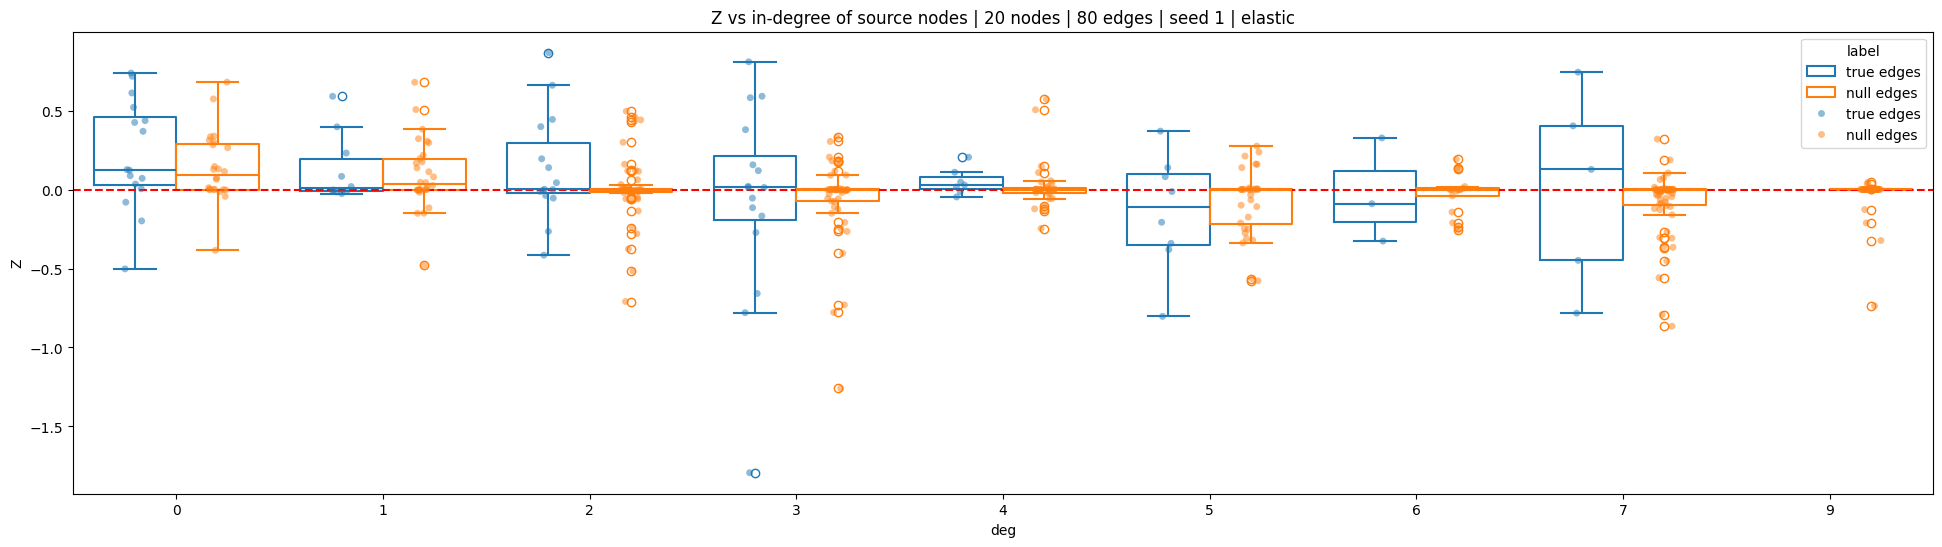

In [6]:
n_nodes = 20
method = 'elastic'
X, B_true, W_est, W_true = load_data(n_nodes, 1, f"v43/v{n_nodes}_{n_nodes * 4}_1_{method}_disable_dag_control")
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)
W11_dagma = W11.copy()

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(24, 6))
src = True
use_out_deg = False
df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_out_deg, use_strip=True, alpha=0.5, notes='elastic')
plt.axhline(y=0, color='r', linestyle='--')

# 40 nodes

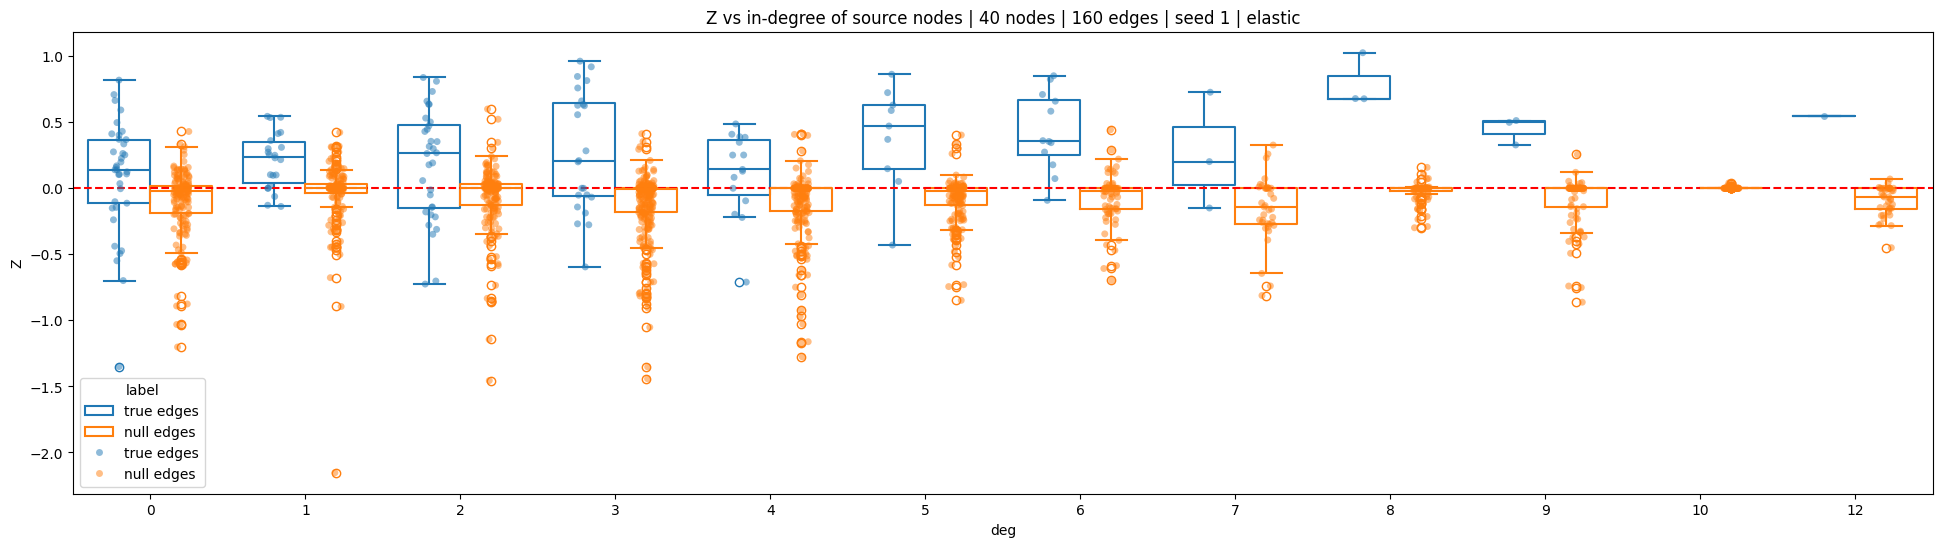

In [3]:
n_nodes = 40
method = 'elastic'
X, B_true, W_est, W_true = load_data(n_nodes, 1, f"v43/v{n_nodes}_{n_nodes * 4}_1_{method}_disable_dag_control")
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)
W11_dagma = W11.copy()

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(24, 6))
src = True
use_out_deg = False
df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_out_deg, use_strip=True, alpha=0.5, notes='elastic')
plt.axhline(y=0, color='r', linestyle='--')

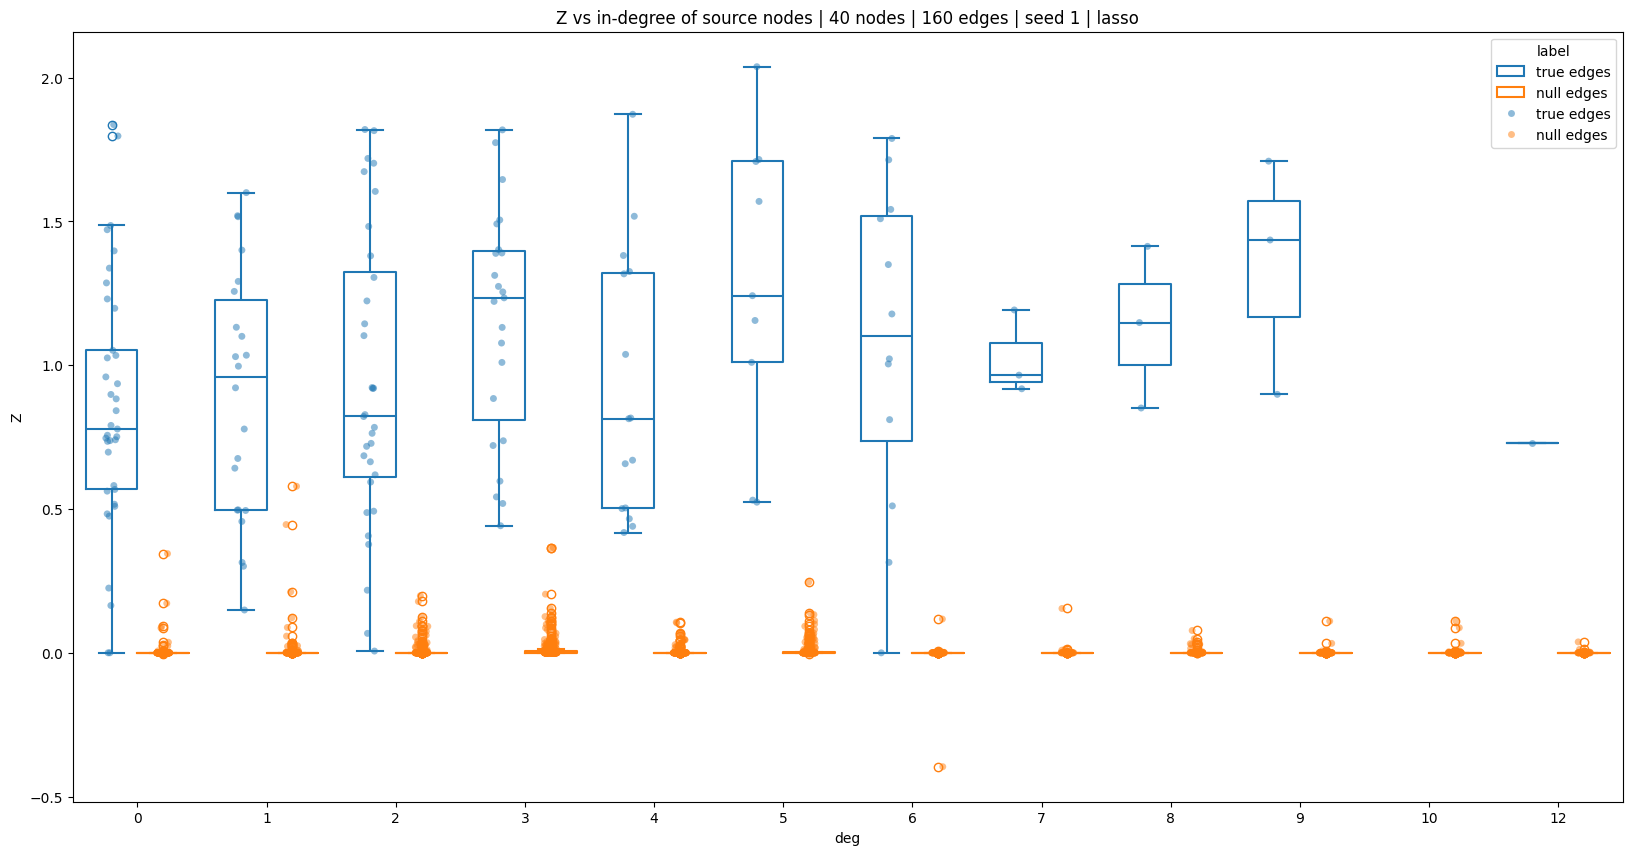

In [22]:
n_nodes = 40
method = 'lasso'
X, B_true, W_est, W_true = load_data(n_nodes, 1, f"v43/v{n_nodes}_{n_nodes * 4}_1_{method}_disable_dag_control")
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)
W11_dagma = W11.copy()

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
src = True
use_out_deg = False
df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_out_deg, use_strip=True, alpha=0.5, notes='lasso')

# 80 nodes

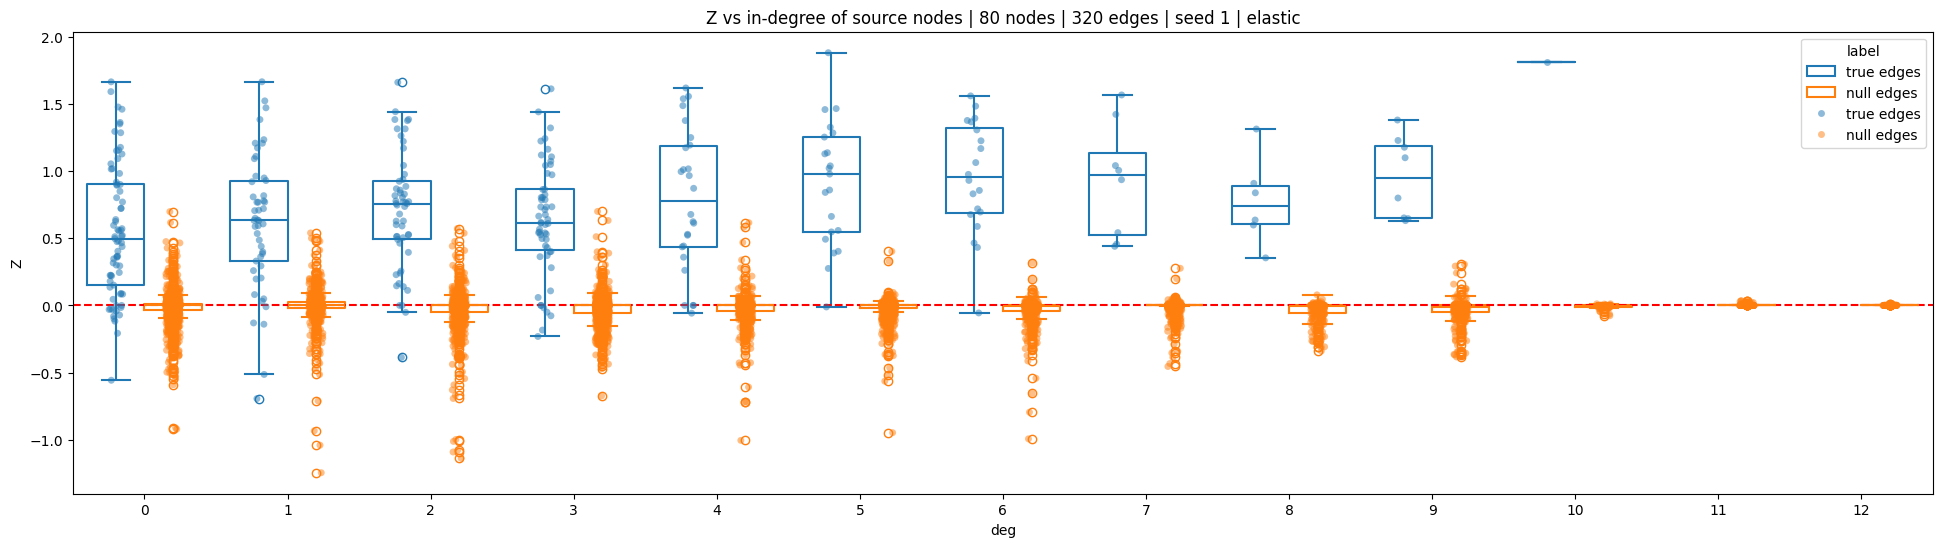

In [4]:
n_nodes = 80
method = 'elastic'
X, B_true, W_est, W_true = load_data(n_nodes, 1, f"v43/v{n_nodes}_{n_nodes * 4}_1_{method}_disable_dag_control")
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)
W11_dagma = W11.copy()

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(24, 6))
src = True
use_out_deg = False
df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_out_deg, use_strip=True, alpha=0.5, notes='elastic')
plt.axhline(y=0, color='r', linestyle='--')

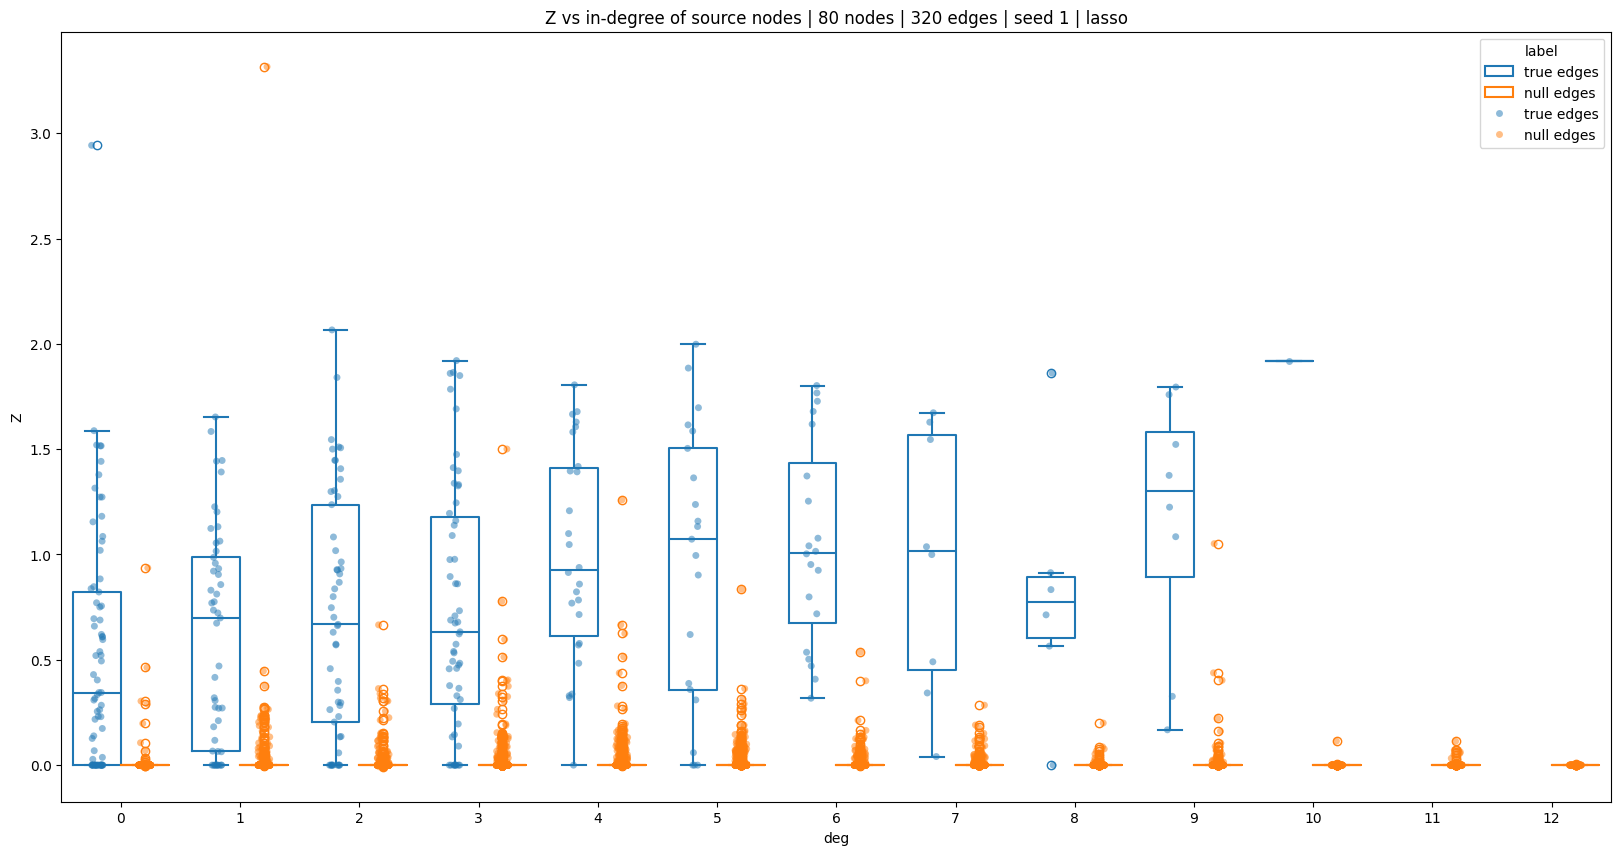

In [23]:
n_nodes = 80
method = 'lasso'
X, B_true, W_est, W_true = load_data(n_nodes, 1, f"v43/v{n_nodes}_{n_nodes * 4}_1_{method}_disable_dag_control")
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)
W11_dagma = W11.copy()

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
src = True
use_out_deg = False
df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_out_deg, use_strip=True, alpha=0.5, notes='lasso')

# 100 nodes

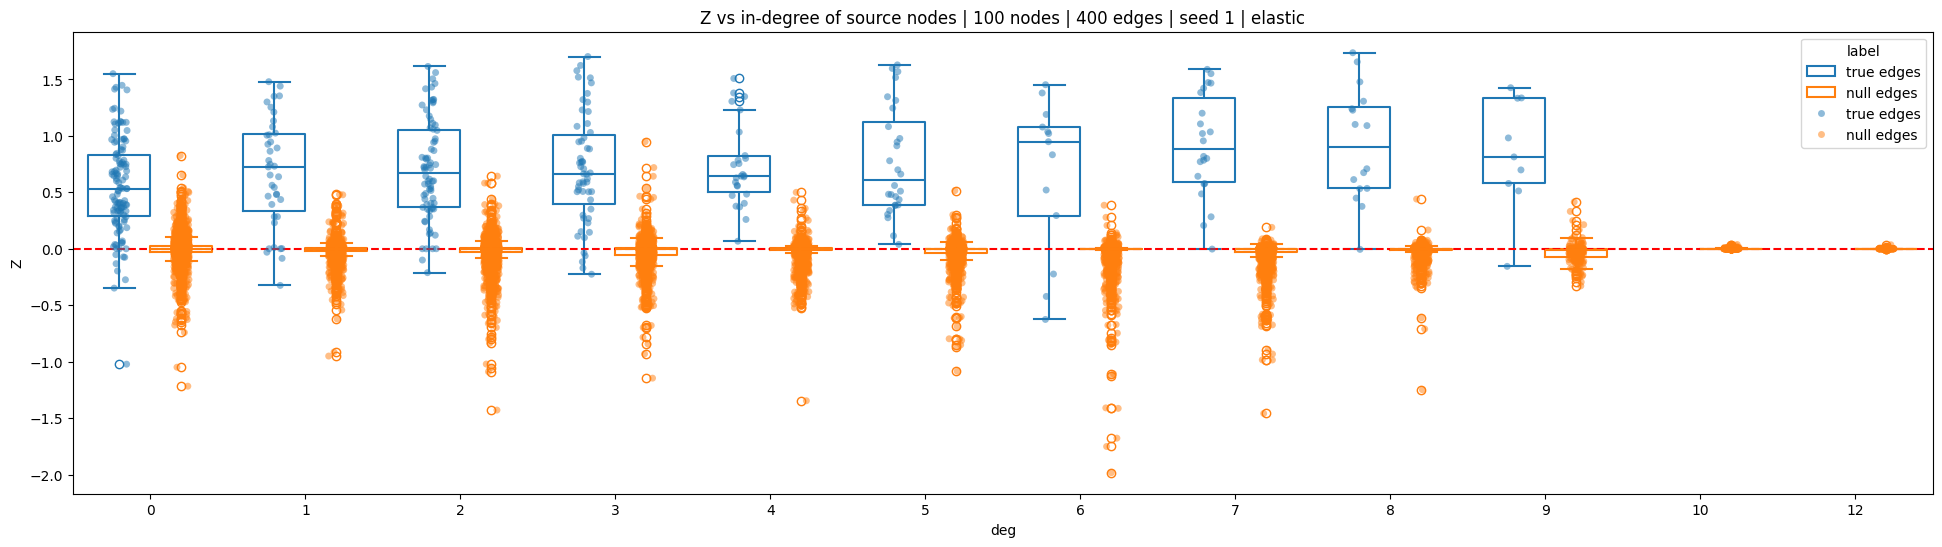

In [7]:
n_nodes = 100
method = 'elastic'
X, B_true, W_est, W_true = load_data(n_nodes, 1, f"v43/v{n_nodes}_{n_nodes * 4}_1_{method}_disable_dag_control")
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)
W11_dagma = W11.copy()

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(24, 6))
src = True
use_out_deg = False
df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_out_deg, use_strip=True, alpha=0.5, notes='elastic')
plt.axhline(y=0, color='r', linestyle='--')

# test assumption

In [7]:
"""
two possibilities
1. knockoffs of starting nodes are the same as original nodes because knockoff can see all other nodes to rebuild itself, and thus incorporating too much
relational information. in this case, the true and null out-edges of both knockoff and original should be the same (not 0), such that the Z comes to 0.
2. knockoffs and original nodes learn 0 weights for both true and null out-edges.

To verify 1: 
1. check weights of out-edges of starting nodes after DAGMA fitting. these weights should be > 0, where W11 should be similar to DAGMA-knockoffDiagn case, 
and W21 should be larger than DAGMA-knockoffDiagn case, such that the new W11 = W21, where the old W11 > W21.
2. (no need) check weights of in-edges of starting nodes with lasso regression. weights of original should be all > 0 compared with DAGMA regression
such that learned knockoff learn more relational information than ... case.
"""


'\ntwo possibilities\n1. knockoffs of starting nodes are the same as original nodes because knockoff can see all other nodes to rebuild itself, and thus incorporating too much\nrelational information. in this case, the true and null out-edges of both knockoff and original should be the same (not 0), such that the Z comes to 0.\n2. knockoffs and original nodes learn 0 weights for both true and null out-edges.\n\nTo verify 1: \n1. check weights of out-edges of starting nodes after DAGMA fitting. these weights should be > 0, where W11 should be similar to DAGMA-knockoffDiagn case, \nand W21 should be larger than DAGMA-knockoffDiagn case, such that the new W11 = W21, where the old W11 > W21.\n2. (no need) check weights of in-edges of starting nodes with lasso regression. weights of original should be all > 0 compared with DAGMA regression\nsuch that learned knockoff learn more relational information than ... case.\n'

In [8]:
"""
1. check weights of out-edges of starting nodes after DAGMA fitting
"""

'\n1. check weights of out-edges of starting nodes after DAGMA fitting\n'

## 40 nodes

Text(0.5, 1.0, 'elastic | 40')

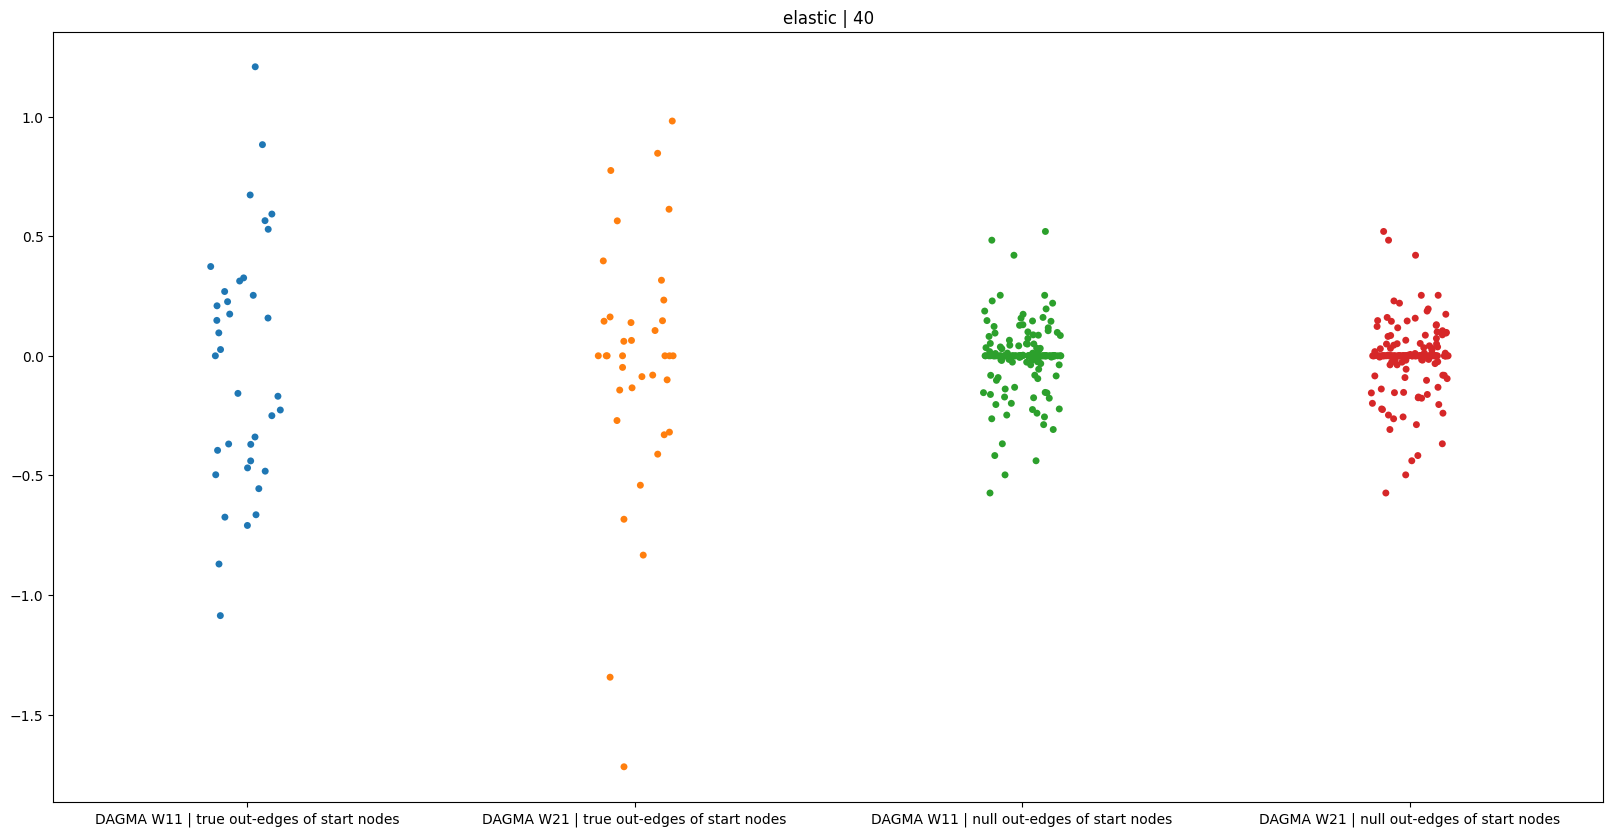

In [9]:
n_nodes = 40
method = 'elastic'
X, B_true, W_est, W_true = load_data(n_nodes, 1, f"v43/v{n_nodes}_{n_nodes * 4}_1_{method}_disable_dag_control")
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

start_n = np.where(in_deg == 0)[0]
all_n = list(range(X.shape[1]))
non_start_n = list(
    set(all_n).difference(set(start_n))
)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
_W11, _W21 = W11.copy(), W21.copy()
_W11[non_start_n, :] = -1000
_W21[non_start_n, :] = -1000
_W11_true, _W11_null = _W11.copy(), _W11.copy()
_W21_true, _W21_null = _W21.copy(), _W11.copy()
_W11_true[~B_true] = -1000
_W21_true[~B_true] = -1000
_W11_null[B_true] = -1000
_W21_null[B_true] = -1000
data_dict = {
    'DAGMA W11 | true out-edges of start nodes': _W11_true[_W11_true != -1000],
    'DAGMA W21 | true out-edges of start nodes': _W21_true[_W21_true != -1000],
    'DAGMA W11 | null out-edges of start nodes': _W11_null[_W11_null != -1000],
    'DAGMA W21 | null out-edges of start nodes': _W21_null[_W21_null != -1000],
}
sns.stripplot(data_dict, alpha=1)
# plt.ylim([-1e-4, 1e-4])
plt.title(f"{method} | {n_nodes}")

Text(0.5, 1.0, 'lasso | 40')

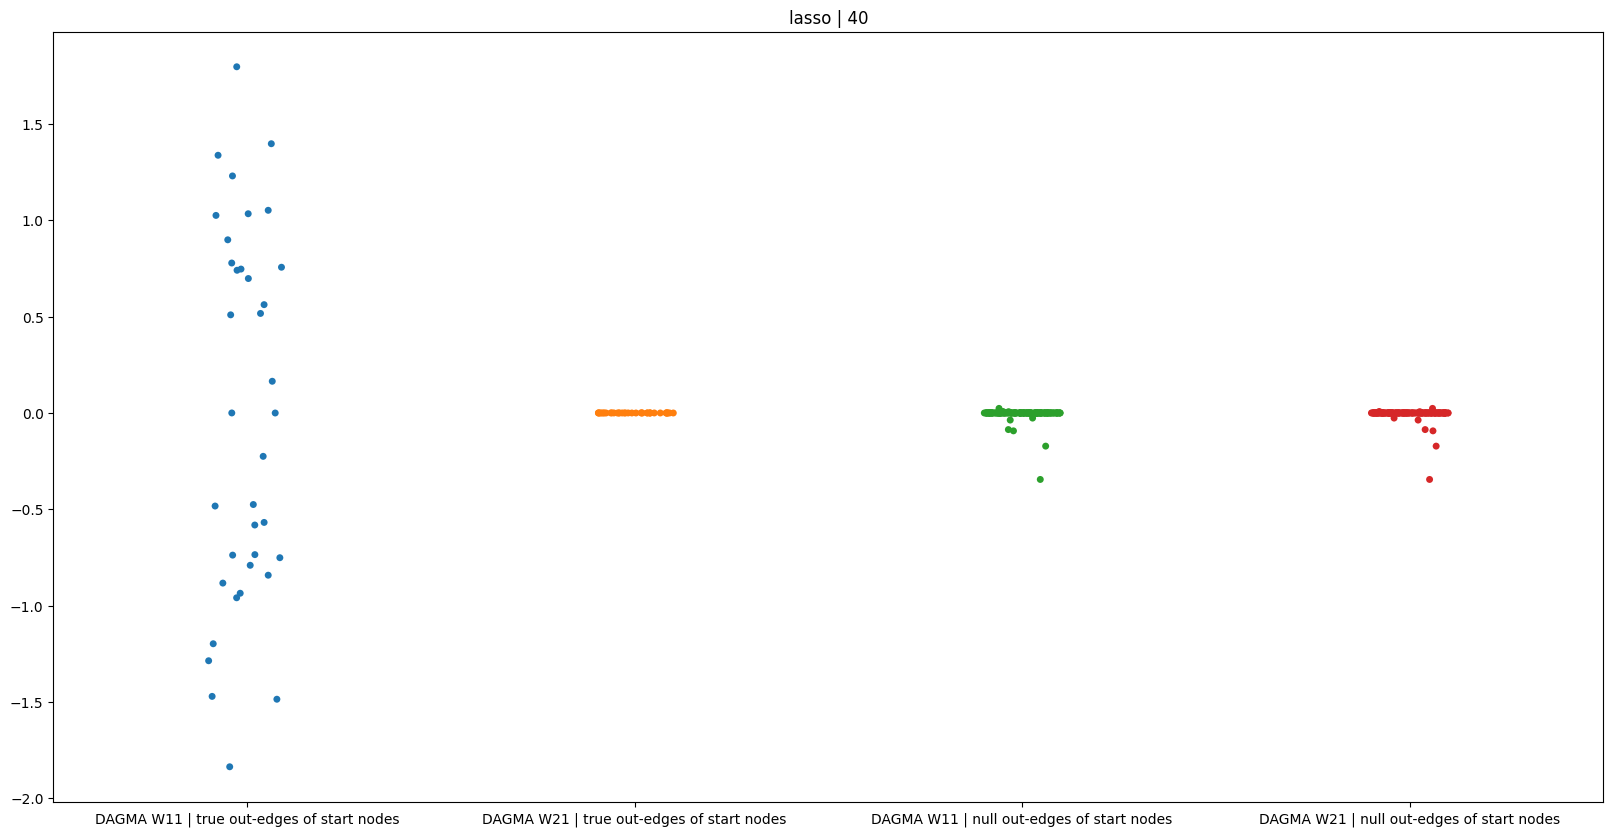

In [10]:
n_nodes = 40
method = 'lasso'
X, B_true, W_est, W_true = load_data(n_nodes, 1, f"v43/v{n_nodes}_{n_nodes * 4}_1_{method}_disable_dag_control")
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

start_n = np.where(in_deg == 0)[0]
all_n = list(range(X.shape[1]))
non_start_n = list(
    set(all_n).difference(set(start_n))
)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
_W11, _W21 = W11.copy(), W21.copy()
_W11[non_start_n, :] = -1000
_W21[non_start_n, :] = -1000
_W11_true, _W11_null = _W11.copy(), _W11.copy()
_W21_true, _W21_null = _W21.copy(), _W11.copy()
_W11_true[~B_true] = -1000
_W21_true[~B_true] = -1000
_W11_null[B_true] = -1000
_W21_null[B_true] = -1000
data_dict = {
    'DAGMA W11 | true out-edges of start nodes': _W11_true[_W11_true != -1000],
    'DAGMA W21 | true out-edges of start nodes': _W21_true[_W21_true != -1000],
    'DAGMA W11 | null out-edges of start nodes': _W11_null[_W11_null != -1000],
    'DAGMA W21 | null out-edges of start nodes': _W21_null[_W21_null != -1000],
}
sns.stripplot(data_dict, alpha=1)
# plt.ylim([-1e-4, 1e-4])
plt.title(f"{method} | {n_nodes}")

## 80 nodes

Text(0.5, 1.0, 'elastic | 80')

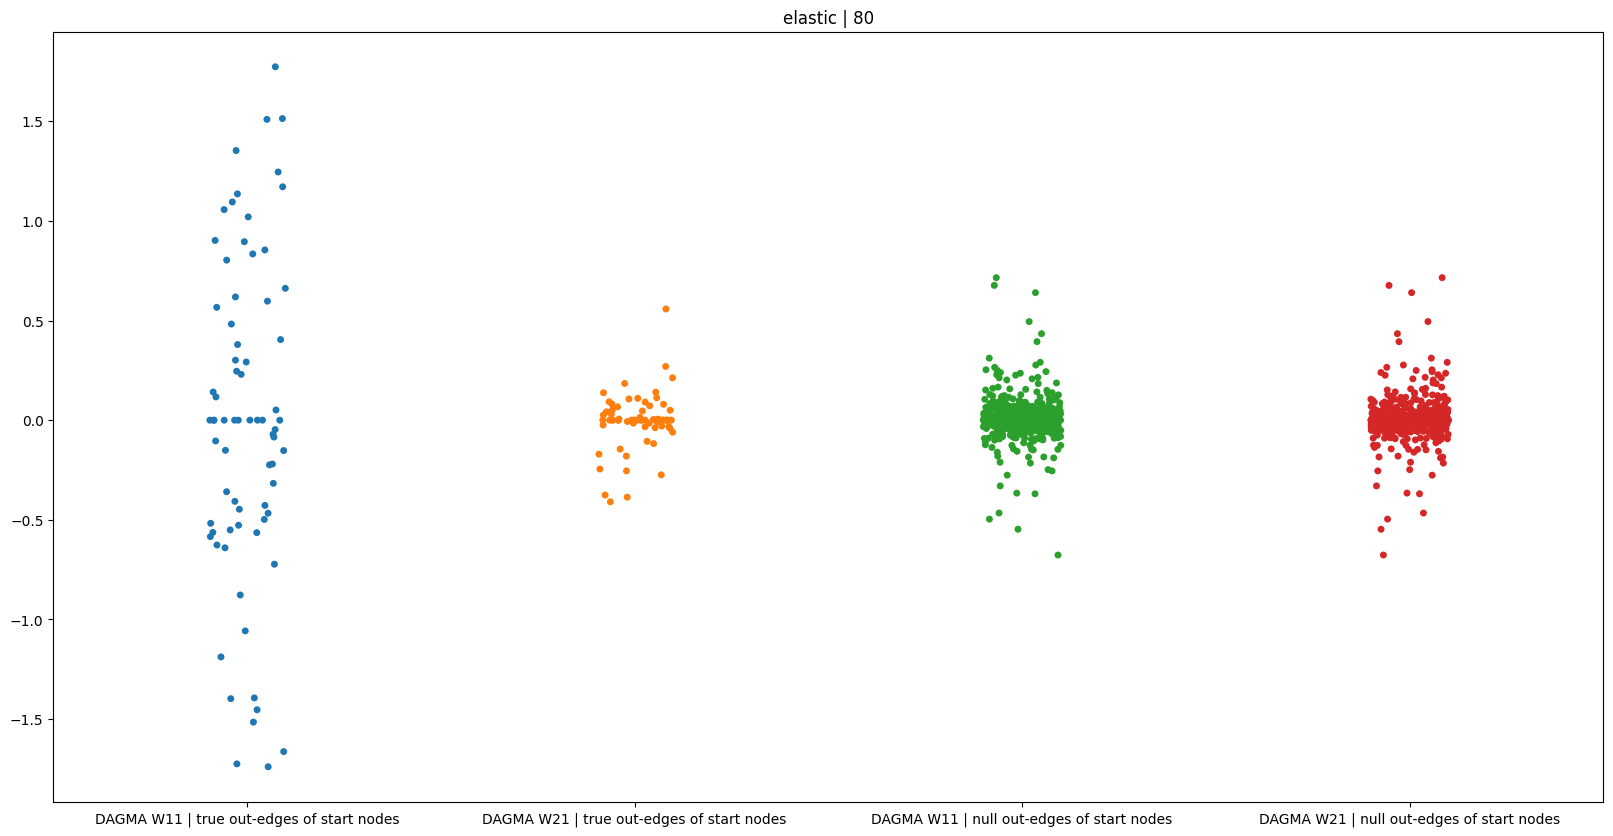

In [11]:
n_nodes = 80
method = 'elastic'
X, B_true, W_est, W_true = load_data(n_nodes, 1, f"v43/v{n_nodes}_{n_nodes * 4}_1_{method}_disable_dag_control")
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

start_n = np.where(in_deg == 0)[0]
all_n = list(range(X.shape[1]))
non_start_n = list(
    set(all_n).difference(set(start_n))
)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
_W11, _W21 = W11.copy(), W21.copy()
_W11[non_start_n, :] = -1000
_W21[non_start_n, :] = -1000
_W11_true, _W11_null = _W11.copy(), _W11.copy()
_W21_true, _W21_null = _W21.copy(), _W11.copy()
_W11_true[~B_true] = -1000
_W21_true[~B_true] = -1000
_W11_null[B_true] = -1000
_W21_null[B_true] = -1000
data_dict = {
    'DAGMA W11 | true out-edges of start nodes': _W11_true[_W11_true != -1000],
    'DAGMA W21 | true out-edges of start nodes': _W21_true[_W21_true != -1000],
    'DAGMA W11 | null out-edges of start nodes': _W11_null[_W11_null != -1000],
    'DAGMA W21 | null out-edges of start nodes': _W21_null[_W21_null != -1000],
}
sns.stripplot(data_dict, alpha=1)
# plt.ylim([-1e-4, 1e-4])
plt.title(f"{method} | {n_nodes}")

Text(0.5, 1.0, 'lasso | 80')

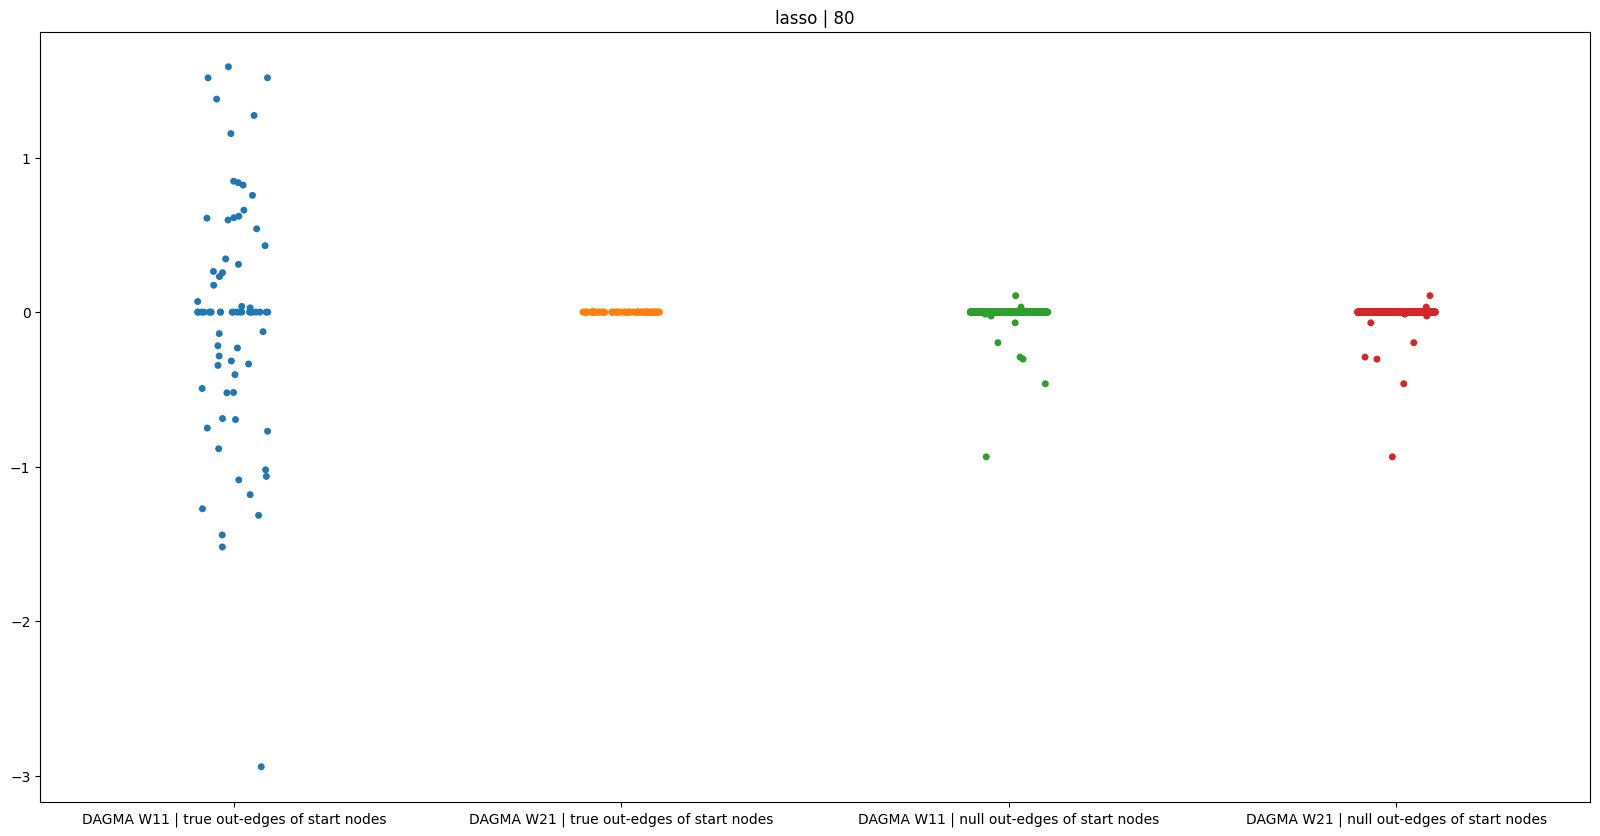

In [12]:
n_nodes = 80
method = 'lasso'
X, B_true, W_est, W_true = load_data(n_nodes, 1, f"v43/v{n_nodes}_{n_nodes * 4}_1_{method}_disable_dag_control")
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

start_n = np.where(in_deg == 0)[0]
all_n = list(range(X.shape[1]))
non_start_n = list(
    set(all_n).difference(set(start_n))
)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
_W11, _W21 = W11.copy(), W21.copy()
_W11[non_start_n, :] = -1000
_W21[non_start_n, :] = -1000
_W11_true, _W11_null = _W11.copy(), _W11.copy()
_W21_true, _W21_null = _W21.copy(), _W11.copy()
_W11_true[~B_true] = -1000
_W21_true[~B_true] = -1000
_W11_null[B_true] = -1000
_W21_null[B_true] = -1000
data_dict = {
    'DAGMA W11 | true out-edges of start nodes': _W11_true[_W11_true != -1000],
    'DAGMA W21 | true out-edges of start nodes': _W21_true[_W21_true != -1000],
    'DAGMA W11 | null out-edges of start nodes': _W11_null[_W11_null != -1000],
    'DAGMA W21 | null out-edges of start nodes': _W21_null[_W21_null != -1000],
}
sns.stripplot(data_dict, alpha=1)
# plt.ylim([-1e-4, 1e-4])
plt.title(f"{method} | {n_nodes}")

# Question

In [16]:
X_tilde_dict = {}
method = 'elastic'
with open(f'/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v43/v40_160_1_{method}_disable_dag_control/knockoff/knockoff_1.pkl', 'rb') as f:
    X_tilde_dict[method] = pickle.load(f).flatten()
    
method = 'lasso'
with open(f'/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v43/v40_160_1_{method}_disable_dag_control/knockoff/knockoff_1.pkl', 'rb') as f:
    X_tilde_dict[method] = pickle.load(f).flatten()

X_tilde_dict['original'] = X.flatten()

Text(0.5, 1.0, 'tilde X distributions | 40 nodes, 160 edges, seed=1')

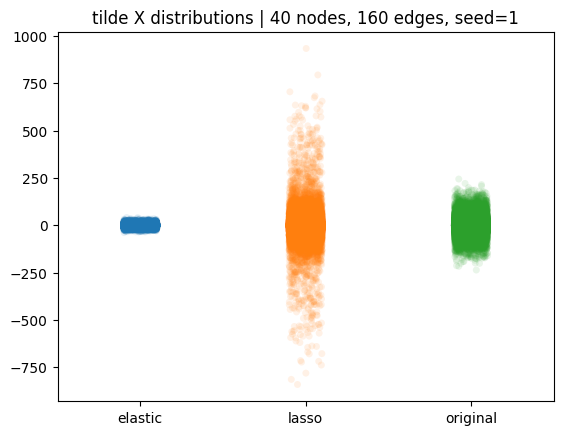

In [25]:
sns.stripplot(X_tilde_dict, alpha=0.1)
plt.title("tilde X distributions | 40 nodes, 160 edges, seed=1")